In [1]:
import tensorflow as tf
import PIL
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape,LeakyReLU,Dropout,Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, )
from tensorflow.keras.optimizers import Adam

In [ ]:
BATCH_SIZE = 128
IM_SHAPE = (64, 64, 3)
LEARNING_RATE = 2e-4
LATENT_DIM=100
EPOCHS = 20

In [15]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:\VAE\dataset\img_align_celeba\img_align_celeba", label_mode=None, image_size=(IM_SHAPE[0], IM_SHAPE[1]), batch_size=BATCH_SIZE
)

<>:2: SyntaxWarning: invalid escape sequence '\V'
<>:2: SyntaxWarning: invalid escape sequence '\V'
C:\Users\prave\AppData\Local\Temp\ipykernel_20268\2237517880.py:2: SyntaxWarning: invalid escape sequence '\V'
  "C:\VAE\dataset\img_align_celeba\img_align_celeba", label_mode=None, image_size=(IM_SHAPE[0], IM_SHAPE[1]), batch_size=BATCH_SIZE


Found 202599 files.


In [17]:
dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [18]:
def preprocess(image):
    return tf.cast(image, tf.float32)/ 127.5 - 1.0

In [20]:
train_dataset = (
    dataset
    .map(preprocess)
    .unbatch()
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE, drop_remainder = True)
    .prefetch(tf.data.AUTOTUNE)
)

In [21]:
for d in train_dataset.take(1):
    print(d.shape)


(128, 64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49938726..1.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.4710976].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.3884249].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4942268..1.4670286].


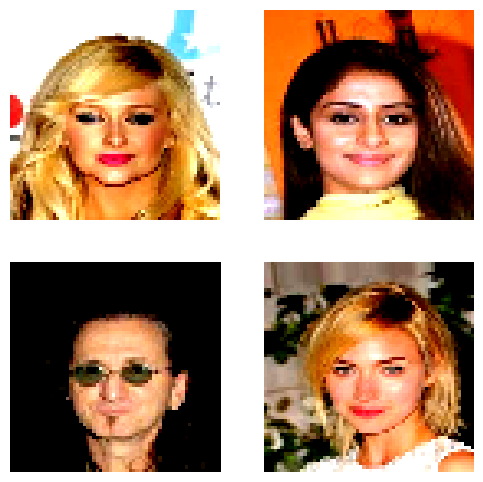

In [22]:
plt.figure(figsize = (6,6))
k = 0
n = 4
for i in range(n):
    ax = plt.subplot(2,2, k+1)
    plt.imshow((d[i]+1/2))
    plt.axis('off')
    k+=1

In [33]:
generator = tf.keras.Sequential([
    Input(shape = (LATENT_DIM,)),
    Dense(4*4*LATENT_DIM),
    Reshape((4,4, LATENT_DIM)),

    Conv2DTranspose(512, kernel_size = 4, strides = 2, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2DTranspose(256, kernel_size = 4, strides = 2, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2DTranspose(128, kernel_size = 4, strides = 2, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2DTranspose(3, kernel_size = 4,activation = tf.keras.activations.tanh, strides = 2, padding = 'same'),


], name ='generator')

In [34]:
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 1600)           │       161,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4, 4, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 8, 8, 512)      │       819,712 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 16, 16, 256)    │     2,097,408 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 32, 32, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 64, 64, 3)      │         6,147 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,612,867 (13.78 MB)

 Trainable params: 3,611,075 (13.78 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [35]:
discrimintator = tf.keras.Sequential([
    Input(shape = (IM_SHAPE[0], IM_SHAPE[1], 3)),

    Conv2D(64, kernel_size=4, strides = 2, padding = 'same'),
    LeakyReLU(0.2),

    Conv2D(128, kernel_size = 4, strides = 2, padding= 'same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2D(256, kernel_size = 4, strides = 2, padding= 'same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2D(1, kernel_size = 4, strides = 2, padding = 'same'),

    Flatten(),
    Dense(1, activation = 'sigmoid')

], name = 'Discriminator')

In [36]:
discrimintator.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 1)        │         4,097 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 664,530 (2.53 MB)

 Trainable params: 663,762 (2.53 MB)

 Non-trainable params: 768 (3.00 KB)